# Setup

In [127]:
import torch
import numpy as np
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.size'] = 22

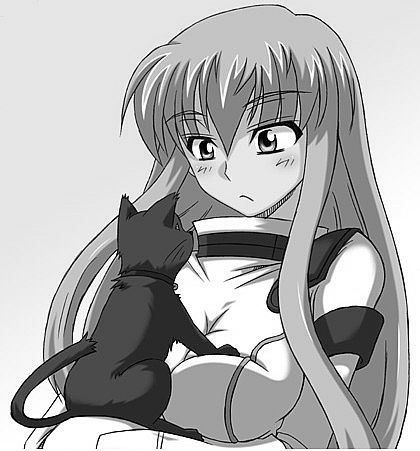

In [3]:
img_pil = Image.open('/app/data/cc.jpg').convert('L')
img_pil

In [4]:
img = torch.tensor(np.asarray(img_pil)/255, dtype=torch.float32)
img.shape

torch.Size([451, 420])

# Edges

## Grad

In [5]:
sobel_filters = torch.tensor([
    [
        [-1, 0, 1.],
        [-2, 0, 2],
        [-1, 0, 1]
    ],
    
    [
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ]
], dtype=torch.float32)

In [6]:
sobel_filters[None].shape

torch.Size([1, 2, 3, 3])

In [7]:
sobel_filters.unsqueeze(1).shape

torch.Size([2, 1, 3, 3])

In [43]:
dXdY = F.conv2d(img[None], sobel_filters.unsqueeze(1), padding='same')

In [44]:
dXdY.shape

torch.Size([2, 451, 420])

In [45]:
img.shape

torch.Size([451, 420])

In [46]:
def to_01(t):
    t -= t.min()
    t /= t.max()
    return t

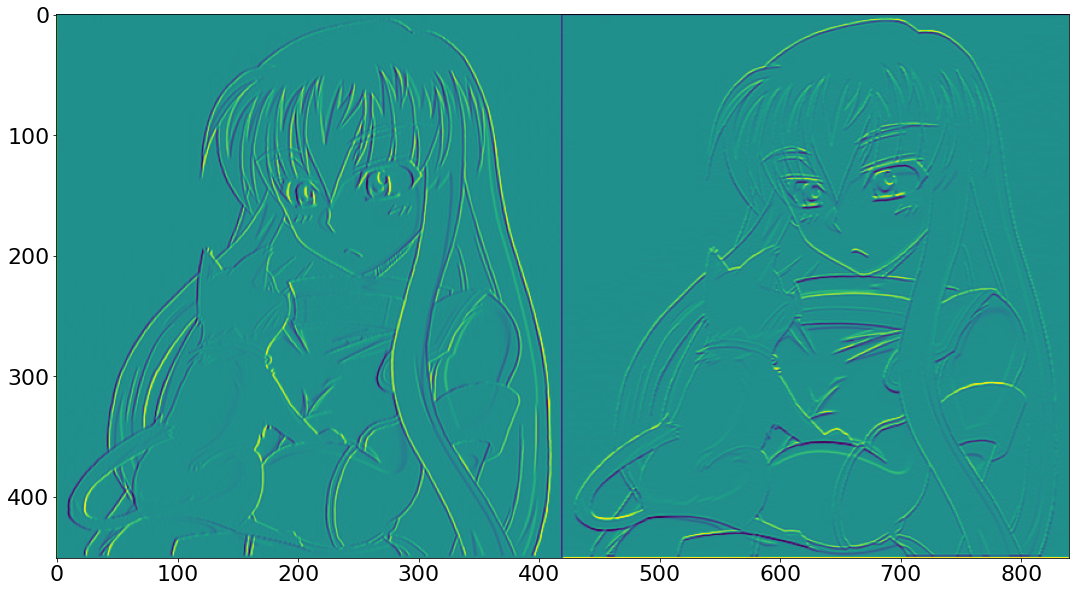

In [47]:
plt.imshow(to_01(torch.cat([i for i in dXdY], dim=1)))

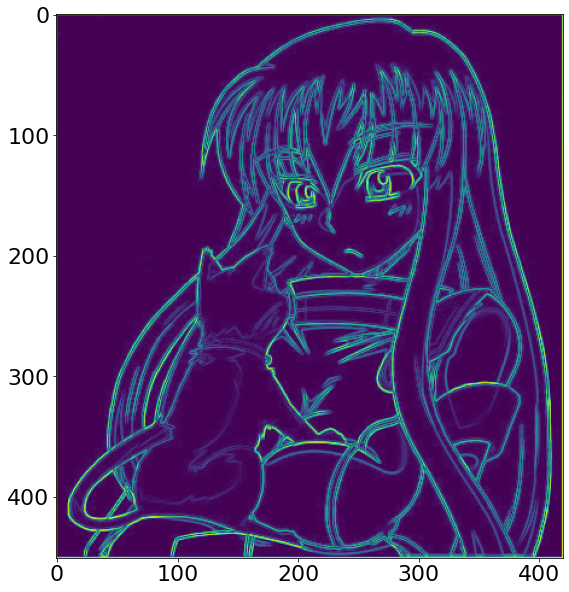

In [48]:
grad_magnitude = dXdY.square().sum(dim=0).sqrt()
plt.imshow(to_01(grad_magnitude))

## Moravec 

In [49]:
ksize = 3

pd = ksize//2

In [50]:
pd

1

In [51]:
h, w = img.shape

In [52]:
img_padded = F.pad(img, [pd]*4)
out = torch.zeros(h, w, ksize, ksize)

In [53]:
for u in range(ksize):
    for v in range(ksize):
        diff = (img - img_padded[u:h+u, v:w+v]).square()
        out[:,:, u,v] = diff
        
out[:,:,pd,pd] = 1e10

out = out.min(dim=-1)[0].min(dim=-1)[0]

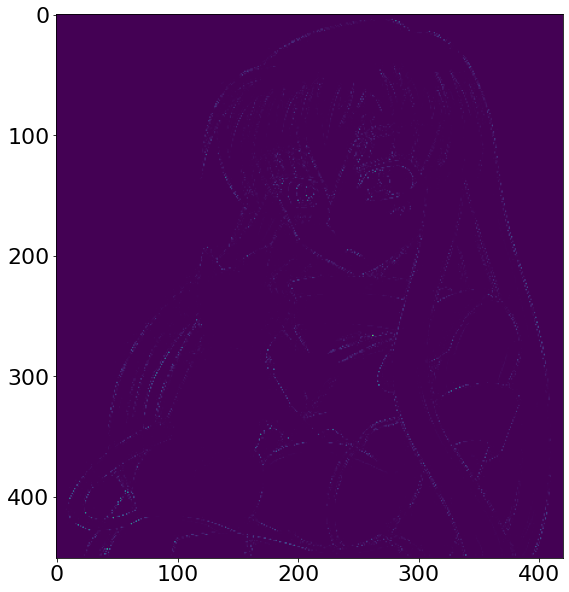

In [54]:
plt.imshow(to_01(out))

In [55]:
(out > 0.2).float().mean()

tensor(0.0016)

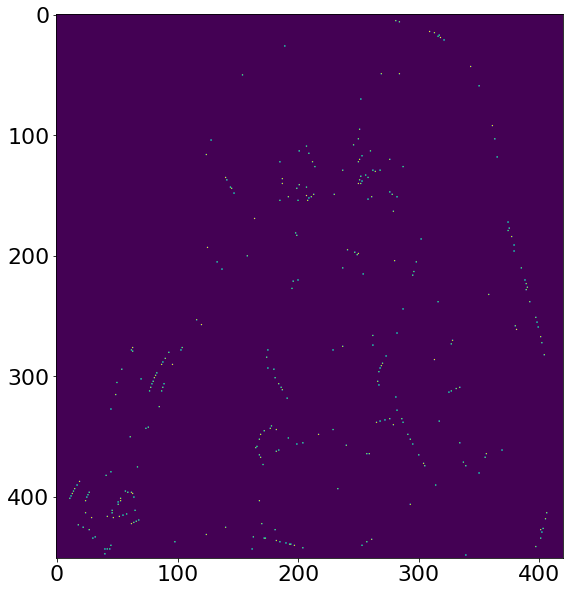

In [56]:
plt.imshow(out > 0.2)

In [57]:
idx = torch.meshgrid(torch.arange(h),torch.arange(w), indexing='ij')
# idx(out > 0.2)

In [58]:
import cv2


def cv2_plot_cross(img_plot, cx, cy, w=20, line_thickness = 1):
    w = 20

    x1 = cx + w//2
    x2 = cx - w//2

    y1 = cy + w//2
    y2 = cy - w//2

    cv2.line(img_plot, (x1, cy), (x2, cy), (0, 255, 0), thickness=line_thickness)
    cv2.line(img_plot, (cx, y1), (cx, y2), (0, 255, 0), thickness=line_thickness)
    return img_plot

In [59]:
mask = out > 0.15
edge_x, edge_y = idx[0][mask], idx[1][mask]

In [60]:
img_plot = img.numpy().copy()

for i in range(len(edge_x)):
    img_plot = cv2_plot_cross(img_plot, edge_y[i].item(), edge_x[i].item())

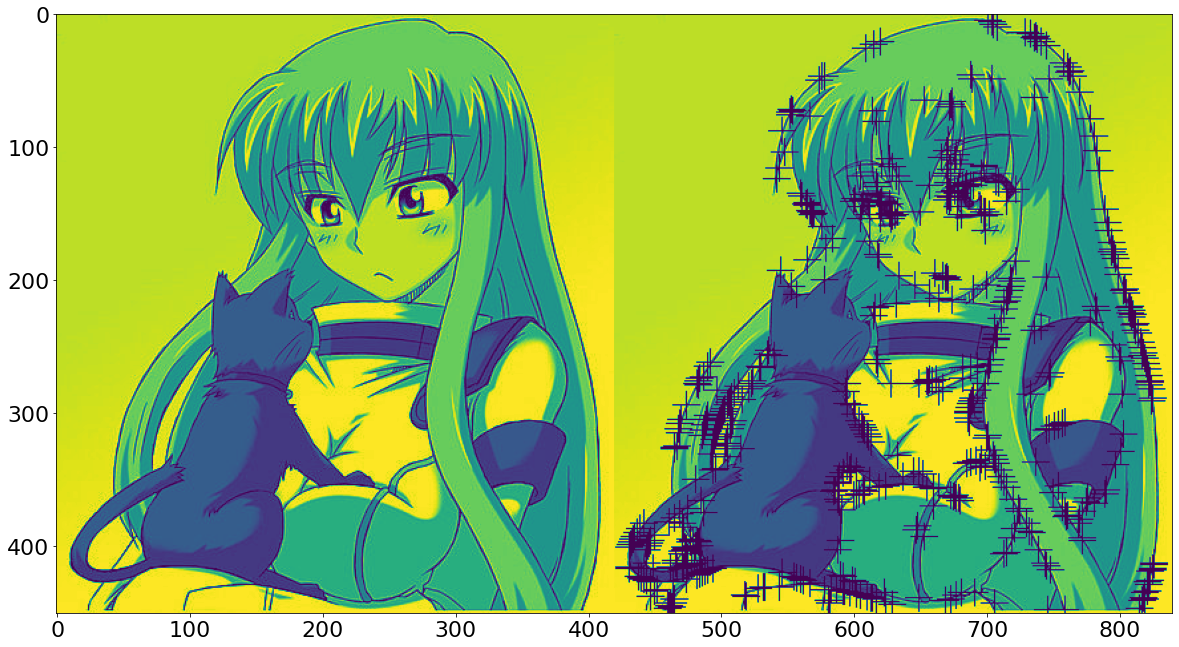

In [61]:
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate([img, img_plot], axis=1))

In [62]:
idx[1]

tensor([[  0,   1,   2,  ..., 417, 418, 419],
        [  0,   1,   2,  ..., 417, 418, 419],
        [  0,   1,   2,  ..., 417, 418, 419],
        ...,
        [  0,   1,   2,  ..., 417, 418, 419],
        [  0,   1,   2,  ..., 417, 418, 419],
        [  0,   1,   2,  ..., 417, 418, 419]])

In [63]:
import plotly.express as px

(array([182.,  56.,  18.,  20.,   9.,   9.,   0.,   0.,   0.,   2.]),
 array([0.2011786 , 0.28106073, 0.36094287, 0.44082502, 0.52070713,
        0.6005893 , 0.6804714 , 0.76035357, 0.8402357 , 0.92011786,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

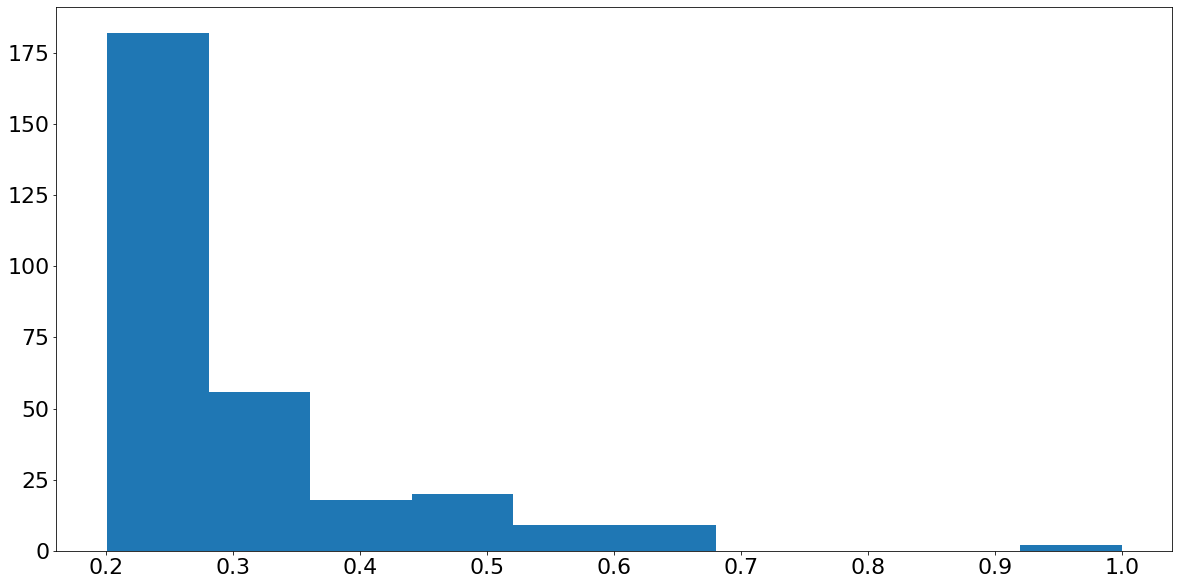

In [64]:
plt.hist(out[out > 0.2].numpy())

# Hough Transform

In [180]:
# img_pil = Image.open('/app/data/cc.jpg').convert('L')
img_pil = Image.open('/app/data/box.png').convert('L')

img = torch.tensor(np.asarray(img_pil)/255, dtype=torch.float32)
h,w = img.shape
dXdY = F.conv2d(img[None], sobel_filters.unsqueeze(1), padding='same')

grad_magnitude = dXdY.square().sum(dim=0).sqrt()
grad_magnitude = to_01(grad_magnitude)
edges = grad_magnitude > .1

In [181]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.size'] = 22

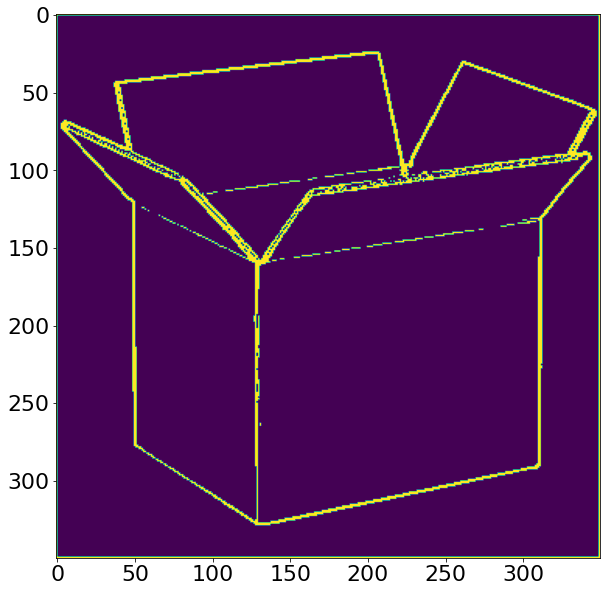

In [182]:
plt.imshow((edges))

In [183]:
idx = torch.meshgrid(torch.arange(h),torch.arange(w), indexing='ij')
idx = torch.stack(idx, dim=0)
idx.shape
# idx[edges]

torch.Size([2, 350, 350])

In [184]:
edge_y, edge_x = idx[0][edges], idx[1][edges]

In [185]:
# pip install seaborn

In [186]:

def get_param_line(a,b, ls = 10):
    p0 = np.array([0, b])
    p1 = p0 + ls * (np.array([-b/a, 0]) - p0)
    return p0, p1

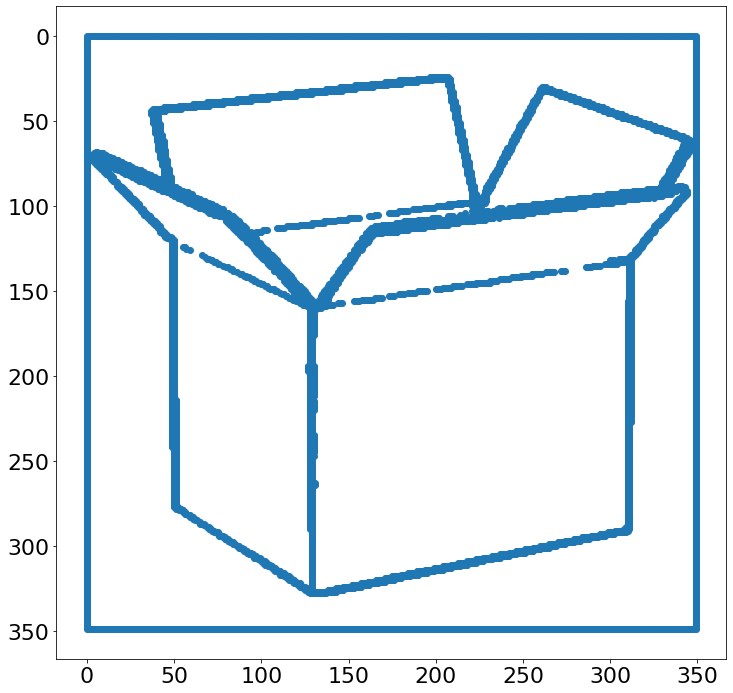

In [189]:
plt.figure(figsize=(12,12))
plt.gca().invert_yaxis()
plt.scatter(edge_x, edge_y)

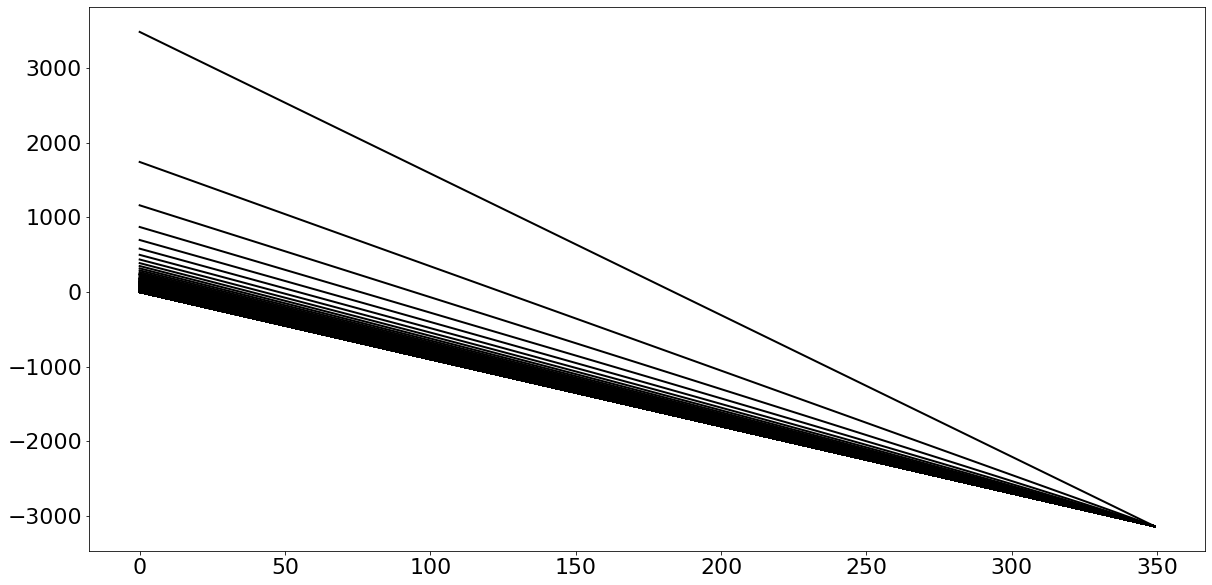

In [198]:
for x, y in zip(edge_x, edge_y):
    p0, p1 = get_param_line(-x, y)
    plt.plot(p0, p1, 'k-', lw=2)